In [120]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [121]:
df = pd.read_csv('data_co2.csv', names=['Year', 'PPM'], skiprows=1)

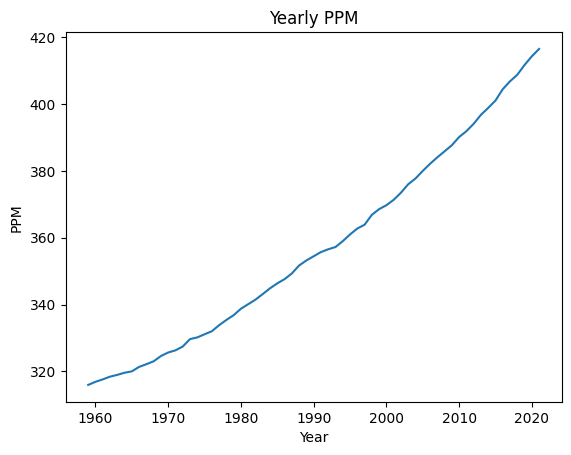

In [122]:
plt.plot(df['Year'], df['PPM'])
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('Yearly PPM')
plt.show()

In [123]:
year = df['Year']
df.drop('Year', axis=1, inplace=True)
data = df.values


def normalize(data, min, max):
    return (data - min) / (max - min)


data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.        ],
       [0.00925649],
       [0.01652234],
       [0.02458445],
       [0.02995919],
       [0.03622972],
       [0.04041007],
       [0.05364786],
       [0.06170996],
       [0.07036926]])

In [124]:
from dataclasses import dataclass


@dataclass
class G:
    TIME, SERIES = year, data_normed
    SPLIT_TIME = int(
        0.8 * len(df))  # on day 80% the training period will end. The rest will belong to the validation set
    WINDOW_SIZE = 5  # how many data points will we take into account to make our prediction
    BATCH_SIZE = 32  # how many items will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000  # we need this parameter to define the Tensorflow sample buffer

In [125]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    """Divide the time series into training and validation set"""
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    """
    We create time windows to create X and y features.
    For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [126]:
# we divide into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# let's create the dataset with time windows
dataset = windowed_dataset(series_train)

In [127]:
def create_uncompiled_model():
    # define a sequential model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                               input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
    ])

    return model

In [128]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mae') < 0.03):
            print("\nMAEthreshold reached. Training stopped.")
            self.model.stop_training = True


# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [129]:
def create_model():
    tf.random.set_seed(51)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])
    return model


model = create_model()

# we train for 20 epochs with and assign the callback
history = model.fit(dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
2/2 [==============================] - 49s 650ms/step - loss: 0.0669 - mae: 0.3097
Epoch 2/50
2/2 [==============================] - 2s 613ms/step - loss: 0.0275 - mae: 0.1984
Epoch 3/50
2/2 [==============================] - 1s 572ms/step - loss: 0.0047 - mae: 0.0803
Epoch 4/50
2/2 [==============================] - 2s 638ms/step - loss: 0.0214 - mae: 0.1644
Epoch 5/50
2/2 [==============================] - 2s 598ms/step - loss: 0.0204 - mae: 0.1609
Epoch 6/50
2/2 [==============================] - 1s 566ms/step - loss: 0.0071 - mae: 0.0928
Epoch 7/50
2/2 [==============================] - 1s 577ms/step - loss: 0.0068 - mae: 0.1079
Epoch 8/50
2/2 [==============================] - 1s 563ms/step - loss: 0.0067 - mae: 0.1096
Epoch 9/50
2/2 [==============================] - 1s 570ms/step - loss: 0.0037 - mae: 0.0673
Epoch 10/50
2/2 [==============================] - 1s 579ms/step - loss: 0.0056 - mae: 0.0837
Epoch 11/50
2/2 [==============================] - 1s 565ms/step - l

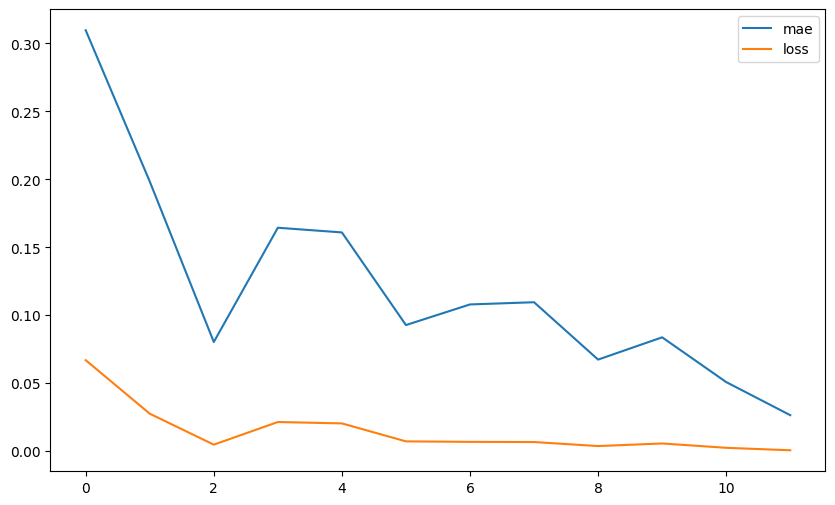

In [130]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [131]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae


def model_forecast(model, series, window_size):
    """This function converts the input series into a dataset with time windows for forecasting"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [132]:
def unnormalize(data, min, max):
    return data * (max - min) + min

2/2 [==============================] - 9s 305ms/step


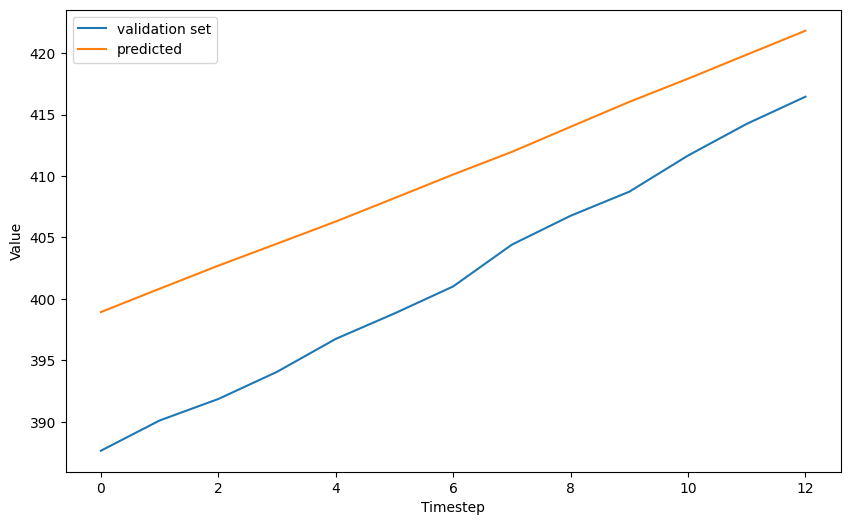

In [133]:
# Prediction on the whole series
all_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

series_valid = unnormalize(series_valid, data.min(axis=0), data.max(axis=0))

val_forecast = unnormalize(val_forecast, data.min(axis=0), data.max(axis=0))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

In [134]:
mse, mae = compute_metrics(series_valid, val_forecast)

mse

# print(f"mse: {mse:.2f}, mae: {mae:.2f}")

array([561.80351247, 456.65722817, 389.22554218, 312.82055588,
       233.27174534, 181.66169391, 136.20443153,  84.99229875,
        63.10817757,  53.30348926,  53.0024568 ,  66.97988546,
        89.53869915])

1/1 [==============================] - 8s 8s/step


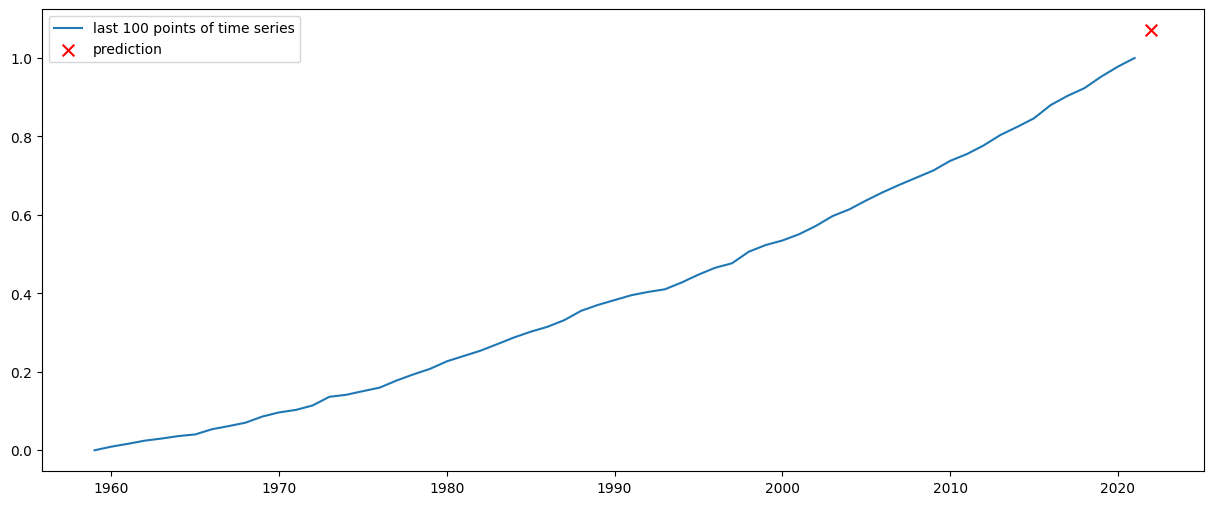

In [135]:
new_forecast = []

new_forecast_series = G.SERIES[-G.WINDOW_SIZE:]

pred = model.predict(new_forecast_series[np.newaxis])

plt.figure(figsize=(15, 6))
plt.plot(G.TIME[-100:], G.SERIES[-100:], label="last 100 points of time series")
plt.scatter(max(G.TIME)+1, pred, color="red", marker="x", s=70, label="prediction")
plt.legend()
plt.show()

In [140]:
model.predict(new_forecast_series[np.newaxis])

1/1 [==============================] - 0s 89ms/step


array([[1.0707624]], dtype=float32)